In [1]:
##from https://github.com/eriklindernoren/Keras-GAN/blob/master/infogan/infogan.py


from __future__ import print_function, division

import matplotlib.pyplot as plt

import numpy as onp

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Geometry import Point3D

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform


from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline



# Using an RDF as a scoring function. 

An EDM could come from points in many dimensions, so it's possible that there are multiple weird ways to satisfy any given EDM. These ways would all be consistent with other EDMs, and so the network will be happy, but the actual 3D realisation of those EDMs might _do not_ work how we expect. 

Alternatively, if we directly learn 3D coordinates, and then compare the euclidean distances to a known distribution, then the network is forced to make the distances consistent with what we expect in 3D space. Put another way, the network can't just put all atoms at the same distance as a carbon-carbon bond distance, because there is not enough volume in 3d dimensions to fit all the atoms surrounding the central atom. The surrounding atoms will thus be forced to move outwards, and hopefully it all settles on a reasonable-looking molecule.  

The below fits a loss function using the distributions of known atom distances. 

The network part uses JAX numpy, hence the original numpy is re-nicknamed `onp`.

In [2]:
##load dataset of QM9 isomers. 
mols = list()
smiles = [i.strip('\n') for i in open('larger_dataset.smi', 'r').readlines()]
for smi in smiles:
    mols.append(Chem.MolFromSmiles(smi))

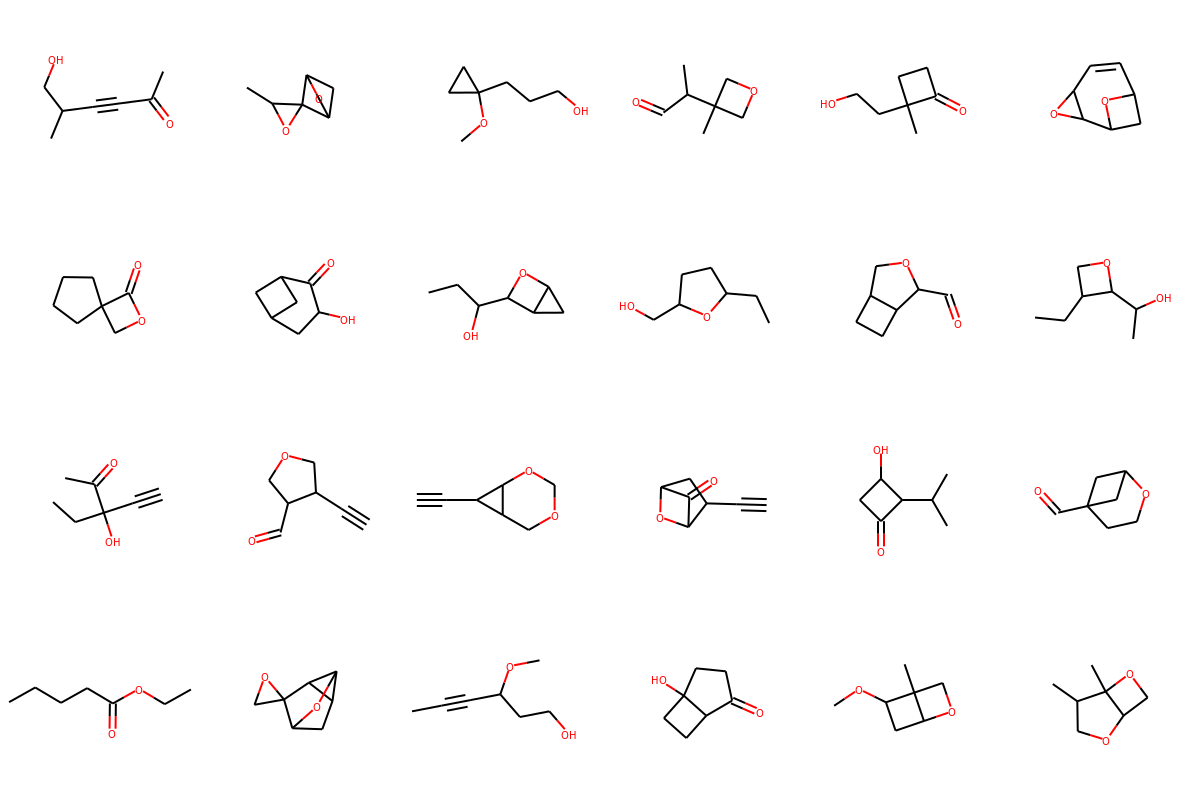

In [3]:
###draw sample
Draw.MolsToGridImage(onp.random.choice(onp.array(mols), 24), molsPerRow=6)


In [4]:
###Calculates 3d coordinates of a molecule using RDKit, and then gets a euclidean distance matrix. 
def getEDM(mol):
    #get 3d coords
    m3 = Chem.AddHs(mol)
    embed = AllChem.EmbedMolecule(m3)
    if embed+1:  
        m3 = Chem.RemoveHs(m3)
        conformer = m3.GetConformer(0)
        positions = conformer.GetPositions()
        return positions
    else:
        return None
    
##Less necessary here, but keeping it around as it may be used later. 
##This permutes the indices of the atoms so you don't always have 
##sequental atoms bonded to each other - the 'bonded' distances in the EDM
##should be able to appear anywhere on the board. 
def permute_edm(edm, atom_identities, num_permutes=1000):
    edm= squareform(edm)
    idx = onp.arange(9)
    edm_list = list()
    atom_list = list()
    
    for _ in range(num_permutes):
        onp.random.shuffle(idx)
        edm_copy = edm[idx][:,idx]
        edm_list.append(squareform(edm_copy))
        atom_list.append(atom_identities[idx])
    return edm_list, atom_list

In [7]:
def returncoords(mol):
    #get 3d coords
    m3 = Chem.AddHs(mol)
    embed = AllChem.EmbedMolecule(m3)
    if embed+1:  
        m3 = Chem.RemoveHs(m3)
        conformer = m3.GetConformer(0)
        positions = conformer.GetPositions()
        return positions
    else:
        return None
    
###Run through molecules and make the EDM dataset. 
edms = list()
atomidx = list()
for count, m in enumerate(onp.random.choice(onp.array(mols), 2000)):
    print(count, end='\r')
    points = getEDM(m)
    if points is None:
        None
    else:
        edm = pdist(points)
        atoms = onp.clip(onp.array([i.GetAtomicNum() for i in m.GetAtoms()])-7, 0, 1)
        el, al = permute_edm(edm, atoms, num_permutes=10)
        for e, a in zip(el, al):
            edms.append(e)
            atomidx.append(a)

In [725]:

dlist = list()
for count, m in enumerate(onp.random.choice(onp.array(mols), 2000)):
    print(count, end='\r')
    points = getEDM(m)
    if points is None:
        None
    else:
        edm = squareform(pdist(points))
        amat = Chem.GetAdjacencyMatrix(m)
        distances = (edm*amat).flatten()
        for d in distances[distances>0]:
            dlist.append(d)
        

KeyboardInterrupt: 

7.993578
2.236191


(array([1.30000e+01, 1.54000e+02, 1.14200e+03, 5.97800e+03, 1.97440e+04,
        4.62260e+04, 8.13940e+04, 1.16537e+05, 1.41940e+05, 1.46712e+05,
        1.32121e+05, 1.13161e+05, 1.04886e+05, 1.11151e+05, 1.24598e+05,
        1.32586e+05, 1.21227e+05, 9.25010e+04, 6.32350e+04, 3.95520e+04,
        2.37830e+04, 1.34450e+04, 7.05900e+03, 3.79500e+03, 1.79900e+03,
        8.34000e+02, 4.04000e+02, 1.68000e+02, 5.00000e+01, 1.00000e+01]),
 array([ 1.351095 ,  1.8871316,  2.4231682,  2.959205 ,  3.4952414,
         4.031278 ,  4.5673146,  5.103351 ,  5.639388 ,  6.1754246,
         6.711461 ,  7.247498 ,  7.7835345,  8.3195715,  8.855608 ,
         9.3916445,  9.927681 , 10.463717 , 10.999754 , 11.53579  ,
        12.071828 , 12.607864 , 13.143901 , 13.679937 , 14.215974 ,
        14.75201  , 15.288047 , 15.824084 , 16.36012  , 16.896156 ,
        17.432194 ], dtype=float32),
 <a list of 30 Patch objects>)

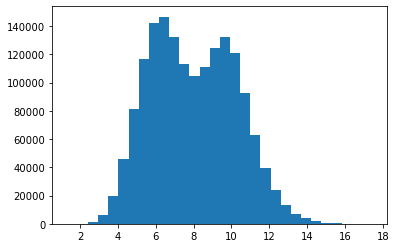

In [690]:
print(np.mean(E_fn(np.array(corlist).reshape(-1,27))[np.triu_indices(len(corlist), 1)]))
print(np.std(E_fn(np.array(corlist).reshape(-1,27))[np.triu_indices(len(corlist), 1)]))
plt.hist(E_fn(np.array(corlist).reshape(-1,27))[np.triu_indices(len(corlist), 1)], bins=30)


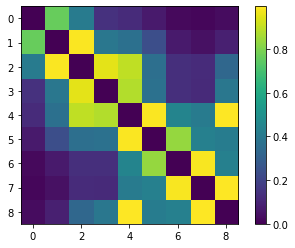

In [920]:
plt.imshow(np.exp(-np.abs(1.5-edm))*(1-np.eye(9)))
plt.colorbar()

0.27237752
0.39010316
0.80130875
0.45670345
0.46791112
0.5188057
0.21333925
0.44501042
0.22561139
0.5221148
0.32129246
0.12887509
0.43844718
0.28036067
0.19598027
0.44501042
0.2738651
0.42630875
0.28656238
0.2602267
0.32738027
0.34352863
0.193009
0.23563421
0.31663525
0.46791112
0.17929184
0.5771761
0.47530943
0.27955183


KeyboardInterrupt: 

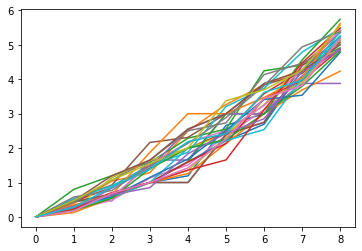

In [904]:
###Run through molecules and make the EDM dataset. 
evals_list = list()
edms = list()
atomidx = list()
for count, m in enumerate(onp.random.choice(onp.array(mols), 100)):
    print(count, end='\r')
    points = getEDM(m)
    if points is None:
        None
    else:
        edm = squareform(pdist(points))
        lt = np.array(np.less_equal(edm, 1.7))
        gt = np.array(np.greater_equal(edm, 0.01))
        A = np.bitwise_and(lt, gt)
        D = np.sum(A, axis=0)*np.eye(9)
        L = D-A
        evals, evecs = onp.linalg.eigh(L)
        print(evals[1])
        plt.plot(evals)
        evals_list.append(evals)

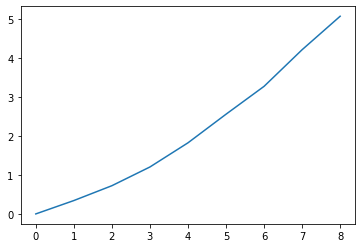

In [532]:
plt.plot(np.mean(evals_list, axis=0))

(array([ 2.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  6., 10.]),
 array([1.19400143, 1.22846753, 1.26293363, 1.29739972, 1.33186582,
        1.36633192, 1.40079801, 1.43526411, 1.46973021, 1.5041963 ,
        1.5386624 ]),
 <a list of 10 Patch objects>)

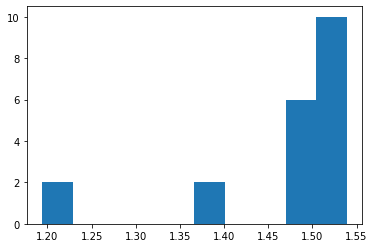

In [504]:

flat = (Chem.GetAdjacencyMatrix(m)*edm).flatten()
plt.hist(flat[flat.nonzero()])

In [498]:
onp.array(A, dtype='int')

array([[0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [493]:
edm

array([[0.        , 1.48348107, 2.44014365, 2.47135225, 3.67924906,
        3.70809657, 4.76959755, 2.55249993, 2.69699192],
       [1.48348107, 0.        , 1.38225456, 1.53520438, 2.31974994,
        2.30948769, 3.39092071, 1.51018785, 2.07002087],
       [2.44014365, 1.38225456, 0.        , 2.40739045, 2.51602039,
        2.59251797, 3.4290422 , 2.42595294, 3.30262683],
       [2.47135225, 1.53520438, 2.40739045, 0.        , 1.5158456 ,
        2.26459711, 3.44803929, 2.0203484 , 1.50673576],
       [3.67924906, 2.31974994, 2.51602039, 1.5158456 , 0.        ,
        1.48911747, 2.43432547, 2.30948933, 2.37517785],
       [3.70809657, 2.30948769, 2.59251797, 2.26459711, 1.48911747,
        0.        , 1.19400143, 1.47165452, 2.2975079 ],
       [4.76959755, 3.39092071, 3.4290422 , 3.44803929, 2.43432547,
        1.19400143, 0.        , 2.39427916, 3.3387522 ],
       [2.55249993, 1.51018785, 2.42595294, 2.0203484 , 2.30948933,
        1.47165452, 2.39427916, 0.        , 1.5386624 ],


# Radial Distribution Function

This is the same as a histogram of the pairwise euclidean distances. It plots the density of expected distances. As seen below, there are a number of peaks, which we can probably assign to (left to right) directly bonded atoms (about 1.3 angstrom), atoms separated by one bond (2-3A), atoms separated by two bonds, etc... 

Text(0, 0.5, 'Density')

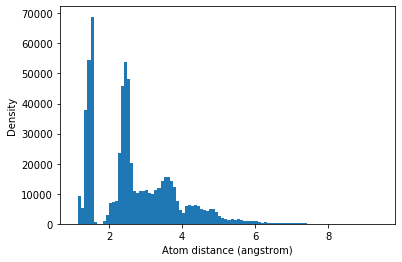

In [8]:
edms = onp.array(edms)
#_ = plt.hist(edms.flatten(), bins=100)
_ = plt.hist(edms.reshape(-1,1), bins=100)
plt.xlabel('Atom distance (angstrom)')
plt.ylabel('Density')

# Can we turn the RDF into a loss function? 

We know the desired RDF. By predicting coordinates with a neural net, we can then generate an RDF for the predicted coordinates (using minibatch to reduce sampling error). Then, just calculate the mean squared error between the predicted coord RDF and true RDF. 

JAX-MD have a handy tool to calculate RDFs which inspired the below. See https://github.com/google/jax-md/blob/master/notebooks/jax_md_cookbook.ipynb

In [9]:
edms_flat = edms.flatten()

In [73]:
import jax.numpy as np
from jax.config import config
from jax import jit, grad, lax, random, vmap
@jit
def calcRDF(flat_distances, bins=100, sigma=0.1):
    exp = np.exp(-0.5 * (flat_distances[:, np.newaxis] -np.linspace(0.0, 2, bins)) ** 2 / sigma** 2)
    gaussian_distances = (exp / np.sqrt(2 * np.pi * sigma ** 2))
    rdf = np.mean(gaussian_distances, axis=0)
    return rdf / np.sum(rdf)*(100)

/home/lewis/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/jax/lib/xla_bridge.py:118: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


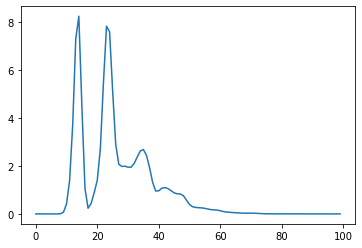

In [15]:
plt.plot(calcRDF(edms_flat))

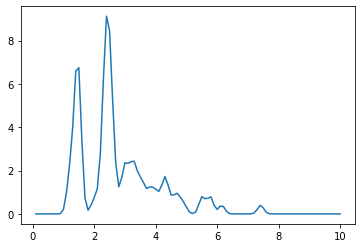

In [16]:
subsample = onp.random.choice(edms_flat, 100)
plt.plot(np.linspace(0.1, 10, 100), calcRDF(subsample))

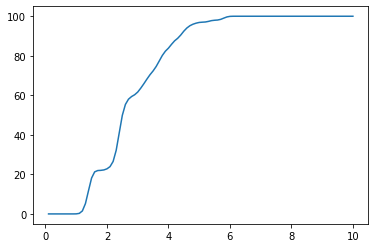

In [17]:
subsample = onp.random.choice(edms_flat, 100)
plt.plot(np.linspace(0.1, 10, 100), onp.cumsum(calcRDF(subsample)))

In [18]:
##Note that at small subsamples, the MSE is large
##due to sampling error. As the subsample size gets
##larger, the subsample better approximates
##the full sample, and MSE is reduced. 
mselist=list()
orig = np.cumsum(calcRDF(subsample))
for i in range(1,40):
    subsample = onp.random.choice(edms_flat, 10*i)
    mse = np.sum(np.power(np.cumsum(calcRDF(subsample))-orig, 2))
    mselist.append(mse)
    print('MSE is:', np.mean(np.power(calcRDF(subsample)-calcRDF(edms_flat), 2)))

MSE is: 1.5150554
MSE is: 0.89038354
MSE is: 0.91128385
MSE is: 0.42607197
MSE is: 0.29003006
MSE is: 0.18909389
MSE is: 0.2029763
MSE is: 0.27636617
MSE is: 0.39516208
MSE is: 0.10523982
MSE is: 0.20532331
MSE is: 0.14035001
MSE is: 0.27646002
MSE is: 0.34838906
MSE is: 0.16885981
MSE is: 0.16573149
MSE is: 0.16296759
MSE is: 0.14695856
MSE is: 0.055914935
MSE is: 0.2042363
MSE is: 0.12095475
MSE is: 0.056895915
MSE is: 0.07324469
MSE is: 0.07443243
MSE is: 0.05637897
MSE is: 0.1187785
MSE is: 0.12375502
MSE is: 0.16023521
MSE is: 0.025169255
MSE is: 0.057920996
MSE is: 0.02980239
MSE is: 0.072405174
MSE is: 0.09135213
MSE is: 0.17108265
MSE is: 0.07437077
MSE is: 0.09314847
MSE is: 0.032846533
MSE is: 0.031905457
MSE is: 0.04296735


# Can we use this loss function in a neural net?

Using jax.stax here for the net. The idea is to generate coordinates from noise (i.e. latent coordinates like a GAN or a VAE) and to take the loss function as defined above (i.e. the inverse of the gmm density)

The code below borrows from two good examples:


There is a great tutorial for doing this: MAML with JAX: https://github.com/ericjang/maml-jax/blob/master/maml.ipynb with more depth explanation at: https://blog.evjang.com/2019/02/maml-jax.html

However some of the code is old. So, also using: https://github.com/google/jax/blob/master/examples/mnist_vae.py which seems more similar to the current task but has no explanation. 

In [19]:
import jax.numpy as np

from jax.config import config
from jax import jit, grad, lax, random, vmap, value_and_grad
from jax.experimental import optimizers, stax
from jax.experimental.stax import Dense, Relu, LeakyRelu, Elu, Dropout, Gelu
from jax.nn.initializers import he_uniform
#from jax.nn import swish

In [20]:
##Amazing resource to quickly take distance matrix of any-dimensional data;
##https://github.com/google/jax/issues/787

#normal:
@jit
def E_fn(conf):
    ri = np.expand_dims(conf, 0)
    rj = np.expand_dims(conf, 1)
    dxdydz = np.power(ri - rj, 2)
    dij = np.sqrt(np.sum(dxdydz, axis=-1))
    return dij

#apparently faster? uses cosine trick.
##However it is susceptible to NaNs. Not using it for this reason.
#@jit
#def E_fn(conf):
#    norms = np.sum(conf ** 2, -1)
#    dij = np.sqrt(norms[..., None] + norms - 2 * np.dot(conf, conf.T))
#    return dij

##Example usage to get pairwise distances of coords or noises:
#E_fn(coords)[np.triu_indices(numsamples, 1)]

##The intuition is explained here:
#https://arxiv.org/abs/1901.09024
#Basically, you want the pairwise distance between any two points
#in latent space to be similar to the pairwise distance between 
#any two points in 3d-coordinate space. To do this, you tell the network
#to maximise the similarity between coordinate-coordinate distance
#and latent-latent distance. 


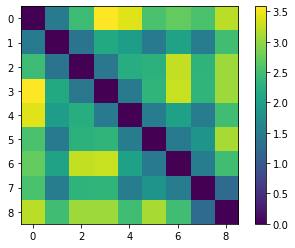

In [26]:
plt.imshow(E_fn(points))
plt.colorbar()

In [361]:
d = E_fn(points)

In [385]:
lt = np.array(np.less_equal(d, 1.5), dtype='int32')
gt = np.array(np.greater_equal(d, 1), dtype='int32')
A = np.bitwise_and(lt, gt)

In [404]:
A = 1.5/(d+0.001)-1.5/0.001*np.eye(9)

In [441]:
d = E_fn(points)
d

DeviceArray([[0.       , 1.46008  , 2.4551802, 3.5829973, 3.414572 ,
              2.552753 , 2.7159772, 2.5525417, 3.2059653],
             [1.46008  , 0.       , 1.3727516, 2.1791265, 2.0091515,
              1.4961119, 2.0685058, 1.5145726, 2.4801612],
             [2.4551802, 1.3727516, 0.       , 1.4167105, 2.2384493,
              2.301177 , 3.2490227, 2.3341227, 3.059881 ],
             [3.5829973, 2.1791265, 1.4167105, 0.       , 1.4806693,
              2.3415828, 3.28649  , 2.341996 , 3.0599399],
             [3.414572 , 2.0091515, 2.2384493, 1.4806693, 0.       ,
              1.5018169, 2.0453649, 1.4993854, 2.4812453],
             [2.552753 , 1.4961119, 2.301177 , 2.3415828, 1.5018169,
              0.       , 1.4940916, 1.860885 , 3.1077542],
             [2.7159772, 2.0685058, 3.2490227, 3.28649  , 2.0453649,
              1.4940916, 0.       , 1.5039665, 2.484667 ],
             [2.5525417, 1.5145726, 2.3341227, 2.341996 , 1.4993854,
              1.860885 , 1.5039665,

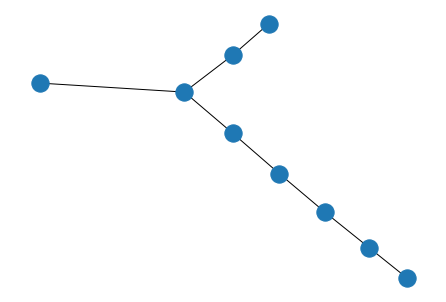

In [442]:

lt = np.array(np.less_equal(d, 1.5), dtype='int32')
gt = np.array(np.greater_equal(d, 0.01), dtype='int32')
A = np.bitwise_and(lt, gt)
import networkx as nx
g = nx.from_numpy_array(A)
nx.draw(g)

In [406]:
lt = np.array(np.less_equal(d, 1.5), dtype='int32')
gt = np.array(np.greater_equal(d, 0.01), dtype='int32')
A = np.bitwise_and(lt, gt)
D = np.sum(A, axis=0)*np.eye(9)

In [407]:
L = D-A

In [408]:
evals, evecs = np.linalg.eigh(L)
evals

DeviceArray([1.6496110e-06, 5.1010461e+00, 5.2955303e+00, 5.7293272e+00,
             6.5028229e+00, 6.7616844e+00, 7.2385993e+00, 7.6491456e+00,
             8.0779572e+00], dtype=float32)

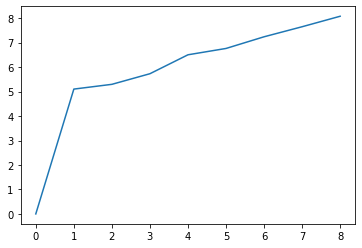

In [409]:
plt.plot(evals)

In [64]:
evals = np.linalg.eigh(L)
ind = np.argsort(evals[0])
evals=evals[0][ind]
connectivity = evals[1]
print(connectivity)

0.14041854


In [75]:
#this is using fiedler vector. 
connectivities = list()
#measure connectivity:
for count, m in enumerate(onp.random.choice(onp.array(mols), 1000)):
    A = Chem.GetAdjacencyMatrix(m)
    D = np.sum(A, axis=0)*np.eye(9)
    L = D-A
    evals, evec = np.linalg.eigh(L)
    ind = np.argsort(evals)
    evals=evals[ind]
    #evec = evec[:,ind]
    connectivity = evals[1]
    connectivities.append(connectivity)


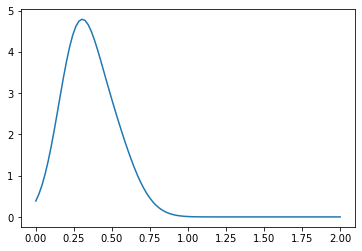

In [81]:
plt.plot(np.linspace(0.0, 2, 100), calcRDF(np.array(connectivities)))

In [ ]:
def getConnectivity(d):
    lt = np.array(np.less_equal(d, 1.5), dtype='int32')
    gt = np.array(np.greater_equal(d, 1), dtype='int32')
    A = np.bitwise_and(lt, gt)
    D = np.sum(A, axis=0)*np.eye(9)
    L = D-A
    evals = np.linalg.eigh(L)
    ind = np.argsort(evals[0])
    evals=evals[0][ind]
    connectivity = evals[1]
    return connectivity
many_coords = batched_makeCoords(p_input, noises_input, key)
many_distances = batched_pairwiseDistances(many_coords)

In [901]:
def init_my_network(latent_dims=50):
    test_rng = random.PRNGKey(1)
    layer_sizes = [784, 1024, 1024, 10]
    _, dec_init_rng = random.split(random.PRNGKey(2))
    decoder_init, decode = stax.serial(
        Dense(5096), Relu, 
        Dropout(0.8),
        Dense(5096), Relu, 
        Dropout(0.8),
        Dense(5096), Relu, 
        Dropout(0.8),
        Dense(5096), Relu, 
        Dropout(0.8),
        Dense(5096), Relu, 
        Dropout(0.8),
        Dense(5096), Relu, 
        Dropout(0.8),
        #Dense(2048), Gelu, 
        #Dropout(0.8),
        #Dense(1024), Gelu, 
        #Dropout(0.8),
        #Dense(1024), Gelu, 
        #Dropout(0.8),

        #Dense(36), Gelu, 
        ##Dropout(0.8),
        #Dense(36), Gelu, 
        ##Dropout(0.8),
        #Dense(36), Gelu, 
        ##Dropout(0.8),
        #Dense(36), Gelu, 
        ##Dropout(0.8),
        #Dense(36), Gelu, 
        ##Dropout(0.8),
        #Dense(36), Gelu, 
        ##Dropout(0.8),
        Dense(27),)
    #W_init=he_uniform()

    _, init_decoder_params =decoder_init(dec_init_rng, (-1, latent_dims))
    opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)
    #opt_init, opt_update, get_params = optimizers.adagrad(step_size=1e-5)
    opt_state = opt_init(init_decoder_params)
    return opt_state, opt_update, decode, get_params

@jit
def makeCoords(params, noises, key):
    coords = decode(params, noises, rng=key)
    return coords

@jit
def calcRDF1(flat_distances, bins=150, sigma=0.05):
    exp = np.exp(-0.5 * (flat_distances[:, np.newaxis] -np.linspace(-1, 15, bins)) ** 2 / sigma** 2)
    gaussian_distances = (exp / np.sqrt(2 * np.pi * sigma ** 2))
    rdf = np.mean(gaussian_distances, axis=0)
    return rdf / np.sum(rdf)*(100)

@jit
def calcRDF2(flat_distances, bins=150, sigma=0.1):
    exp = np.exp(-0.5 * (flat_distances[:, np.newaxis] -np.linspace(0.0, 15, bins)) ** 2 / sigma** 2)
    gaussian_distances = (exp / np.sqrt(2 * np.pi * sigma ** 2))
    rdf = np.mean(gaussian_distances, axis=0)
    return rdf / np.sum(rdf)*(100)

@jit
def getConnectivity(d_i):    
    lt = np.array(np.less_equal(d_i, 1.7))
    gt = np.array(np.greater_equal(d_i, 0.01))
    A = np.bitwise_and(lt, gt)
    D = np.sum(A, axis=0)*np.eye(9)
    L = D-A
    evals, evecs = np.linalg.eigh(L)
    #connectivity = evals[1]
    return evals#connectivity

@jit
def pairwise_distances(coords_in):
    xyz1 = coords_in.reshape(9,3)
    d0 = np.abs(xyz1[:,0].reshape([-1,1]) - xyz1[:,0])
    d1 = np.abs(xyz1[:,1].reshape([-1,1]) - xyz1[:,1])
    d2 = np.abs(xyz1[:,2].reshape([-1,1]) - xyz1[:,2])
    return (d0+d1+d2)

@jit
def getFlatDistance(d_in):
    return d_in[np.triu_indices(9,1)]

#true_connectivities = calcRDF1(np.array(connectivities))
true_distances = calcRDF2(np.array(edms_flat))
true_evals = np.mean(evals_list, axis=0)
true_evals_std = np.std(evals_list,axis=0)

@jit
def loss(p_input, noises_input, key):
    ##get the distances. 
    many_coords = batched_makeCoords(p_input, noises_input, key)
    many_distances = batched_pairwiseDistances(many_coords)
    conns = vmap(getConnectivity)(many_distances)
    #batch_conns = calcRDF1(conns)
    distances = vmap(getFlatDistance)(many_distances)
    batch_rdf = calcRDF2(distances.flatten())
    
    #MSE's
    mse1 = np.mean((true_evals-np.mean(conns, axis=0))**2)
    mse1_std = np.mean((true_evals_std-np.std(conns, axis=0))**2)
    mse2 = np.mean((true_distances-batch_rdf)**2)
    
    #instance distances:
    distmat = E_fn(many_coords)[np.triu_indices(noises_input.shape[0], 1)]
    instance_distances = (8-np.mean(distmat))**2
    return mse1+mse2+2*mse1_std+instance_distances + (2.2-np.std(distmat))**2


batched_makeCoords = vmap(makeCoords, in_axes=(None, 0, None))
batched_pairwiseDistances = vmap(pairwise_distances, in_axes=(0))
gradient_of_loss = grad(loss)

In [902]:
latent_dims = 5
opt_state, opt_update, decode, get_params = init_my_network(latent_dims=latent_dims)

key = random.PRNGKey(3)
key, noise_key = random.split(key)

loss_list = list()

get_loss_and_grad = lambda p_in, noises_in, key: value_and_grad(loss)(p_in, noises_in, key)

def step(i, opt_state, key):
    key, noise_key = random.split(key)
    noises = random.normal(noise_key, shape=(256, latent_dims))
    p = get_params(opt_state)   
    l,g = get_loss_and_grad(p, noises, key)
    if i%50==0:
        loss_list.append(l)
        print(l)
    return opt_update(i, g, opt_state), key

for i in tqdm_notebook(range(100000)):
    opt_state, key = step(i, opt_state, key)


/home/lewis/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


134.05823


KeyboardInterrupt: 

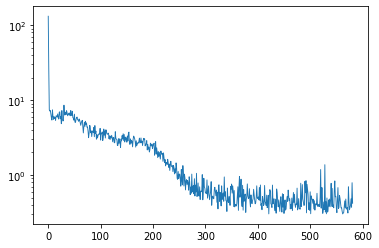

In [838]:
#plt.plot(onp.log(loss_list), linewidth=0.1)

plt.plot(loss_list, linewidth=0.9)
plt.yscale('log')

In [839]:
key, noise_key = random.split(key)
noises = random.normal(noise_key, shape=(256, latent_dims))
p = get_params(opt_state)   

many_coords = batched_makeCoords(p, noises, key)
many_distances = batched_pairwiseDistances(many_coords)

In [840]:
many_distances[1]

DeviceArray([[0.        , 3.532036  , 2.4804068 , 4.3021827 , 2.5509143 ,
              2.4344885 , 1.5400906 , 1.3872269 , 3.2935658 ],
             [3.532036  , 0.        , 1.6017737 , 3.4128714 , 1.4328731 ,
              3.1556177 , 2.4900103 , 3.8224888 , 1.9825528 ],
             [2.4804068 , 1.6017737 , 0.        , 4.2355084 , 1.4686539 ,
              3.9782548 , 2.48739   , 2.5838058 , 2.2550454 ],
             [4.3021827 , 3.4128714 , 4.2355084 , 0.        , 3.1271336 ,
              2.7648478 , 3.9565392 , 5.5167494 , 2.8739796 ],
             [2.5509143 , 1.4328731 , 1.4686539 , 3.1271336 , 0.        ,
              2.5096009 , 1.5088885 , 2.6543136 , 0.88478434],
             [2.4344885 , 3.1556177 , 3.9782548 , 2.7648478 , 2.5096009 ,
              0.        , 1.490865  , 2.7519016 , 2.1143136 ],
             [1.5400906 , 2.4900103 , 2.48739   , 3.9565392 , 1.5088885 ,
              1.490865  , 0.        , 1.5602101 , 2.2515397 ],
             [1.3872269 , 3.8224888 , 2.5

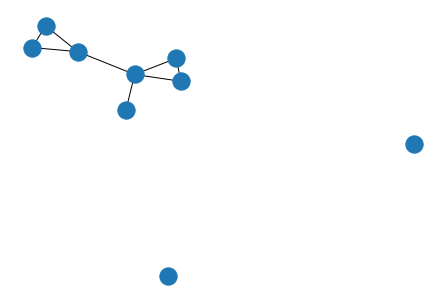

In [849]:
d = many_distances[6]
lt = np.array(np.less_equal(d, 1.7), dtype='int32')
gt = np.array(np.greater_equal(d, 0.01), dtype='int32')
A = np.bitwise_and(lt, gt)
import networkx as nx
g = nx.from_numpy_array(A)
nx.draw(g)

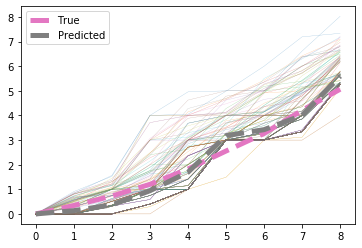

In [850]:
el = list()
for d in many_distances:
    evals = getConnectivity(d)
    
    plt.plot(evals, linewidth=0.25, alpha=0.5)
    el.append(evals)
    
el = np.array(el)
plt.plot(true_evecs, linewidth=5, linestyle='--', label='True')
plt.plot(np.mean(el,axis=0), linewidth=5, linestyle='--', label='Predicted')
plt.legend()

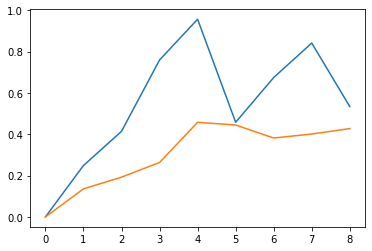

In [851]:
plt.plot(np.std(el, axis=0))
plt.plot(np.std(evals_list, axis=0))

In [852]:
np.mean((np.std(el, axis=0)- np.std(evals_list, axis=0))**2)

DeviceArray(0.09437013, dtype=float32)

7.697692
2.110895


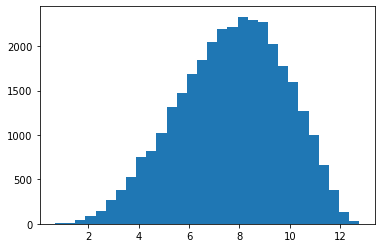

In [853]:
plt.hist(E_fn(many_coords)[np.triu_indices(256,1)], bins=30)
print(np.mean(E_fn(many_coords)[np.triu_indices(256,1)]))
print(np.std(E_fn(many_coords)[np.triu_indices(256,1)]))

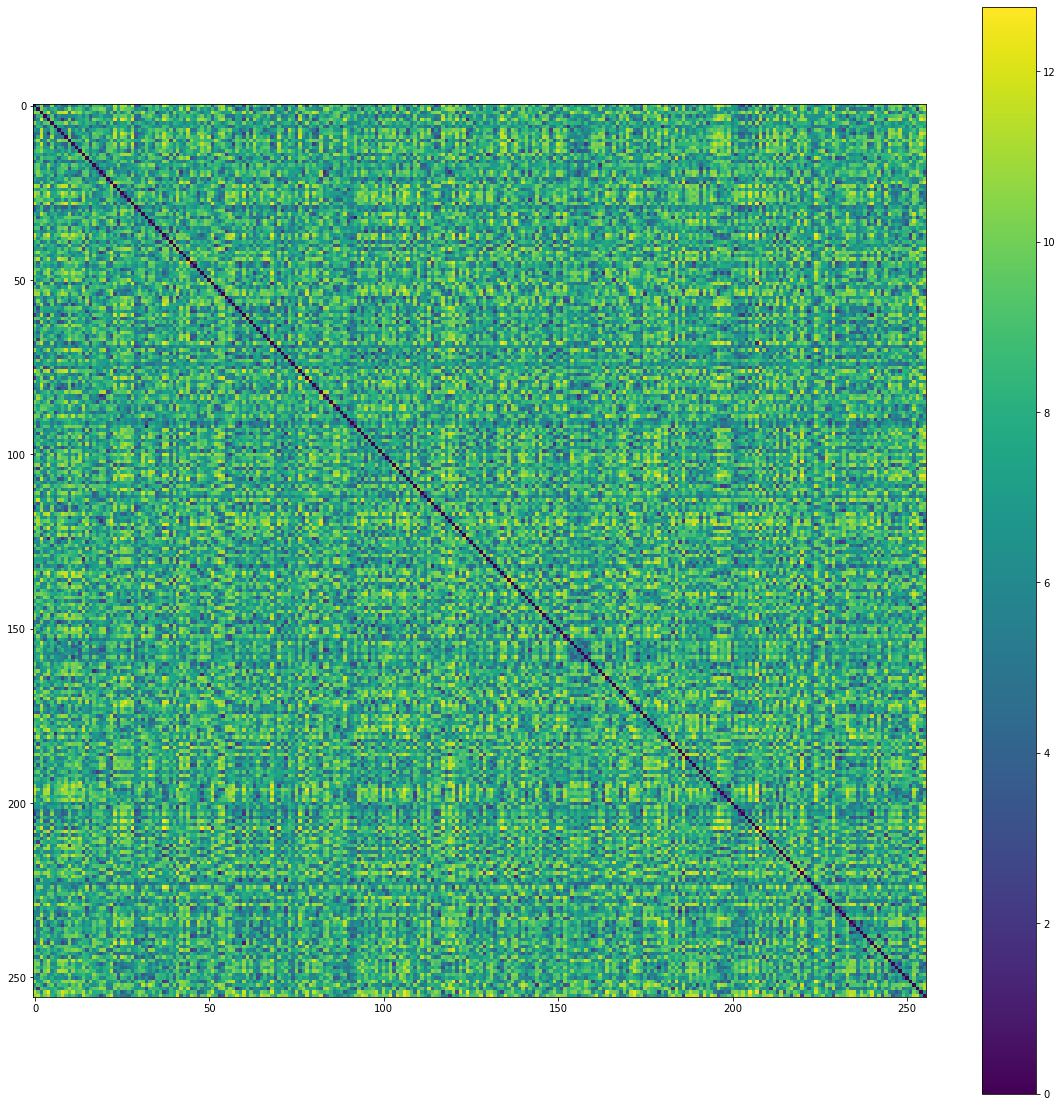

In [854]:
plt.figure(figsize=(20,20))
plt.imshow(E_fn(many_coords))
plt.colorbar()

# How does it look?

Predict some coordinates and plot to see if they are at least consistent with the expected radial distribution function. 

In [855]:
key, noise_key = random.split(key)
numsamples = 28
noise = random.normal(noise_key, shape=(numsamples, latent_dims))

p = get_params(opt_state)
coords = decode(p, noise,rng=key).reshape(numsamples,-1)

predicted_samples = list()
for c in coords:
    reshaped = c.reshape(9,3)
    predicted_samples.append(reshaped)


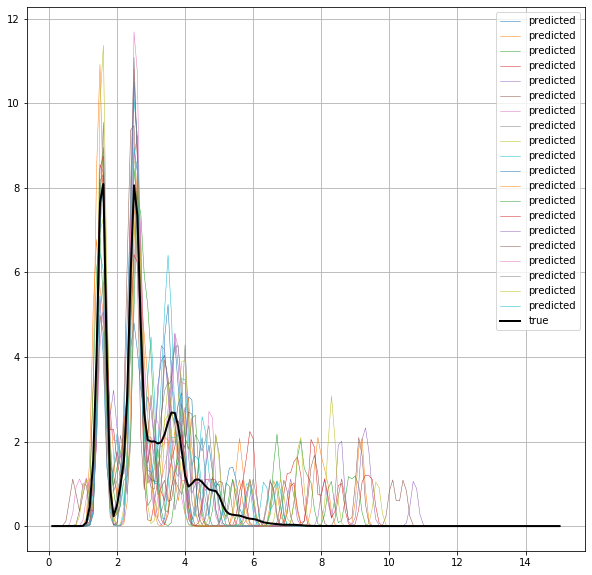

In [858]:
plt.figure(figsize=(10,10))
for k in range(20):
    
    plt.plot(np.linspace(0.1, 15, 150), calcRDF2(all_distances[k]),
             linewidth=0.5, label='predicted')
#for d in all_distances:
#    plt.plot(np.linspace(0.1, 10, 200), calcRDF(np.array(d).flatten()), linewidth=0.25)
plt.plot(np.linspace(0.1, 15, 150), calcRDF2(edms_flat), label='true', c='k', linewidth=2)
plt.grid()
plt.legend()

0.7750836


(-5, 5)

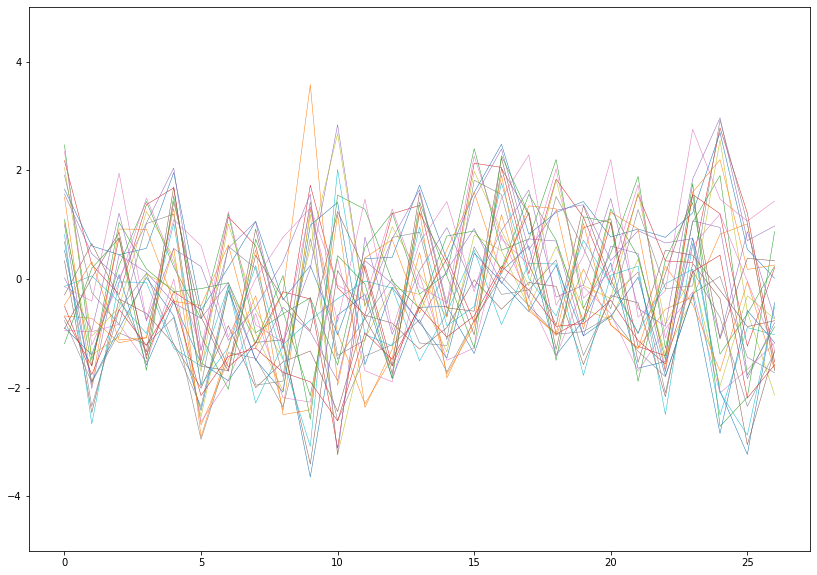

In [861]:
plt.figure(figsize=(14,10))
print(np.min(np.std(coords, axis=0)))
for c in coords:
    plt.plot(c, linewidth=0.5)
plt.ylim(-5,5)


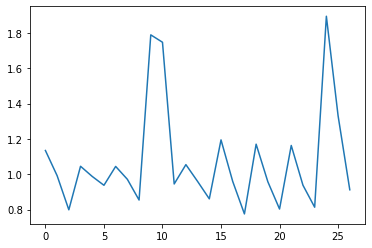

In [862]:
plt.plot(np.std(coords, axis=0))

In [863]:
def E_fn(conf):
    ri = np.expand_dims(conf, 0)
    rj = np.expand_dims(conf, 1)
    dxdydz = np.power(ri - rj, 2)
    dij = np.sqrt(np.sum(dxdydz, axis=-1))
    return dij

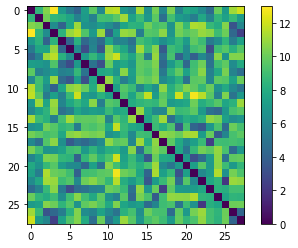

In [864]:
plt.imshow(E_fn(coords))
plt.colorbar()

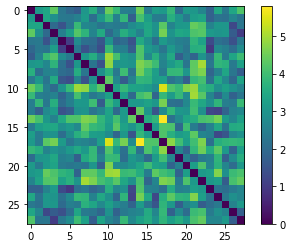

In [865]:
plt.imshow(E_fn(noise))
plt.colorbar()

In [961]:
def E_fn(conf):
    norms = np.sum(conf ** 2, -1)
    dij = np.sqrt(norms[..., None] + norms - 2 * np.dot(conf, conf.T))
    return dij

#plt.imshow(E_fn(coords)[np.triu_indices(numsamples)])
#plt.colorbar()

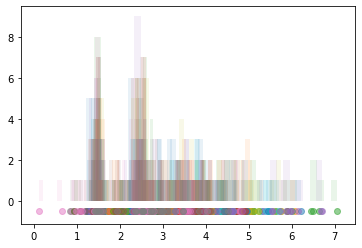

In [866]:
all_distances = list()
for idx in range(numsamples):
    c = predicted_samples[idx]
    distances = pairwise_distances(c)[np.triu_indices(9,1)]
    all_distances.append(distances)
    plt.hist(distances, bins=36, alpha=0.1)
    plt.scatter(distances, np.zeros(len(distances))-0.5, alpha=0.5)

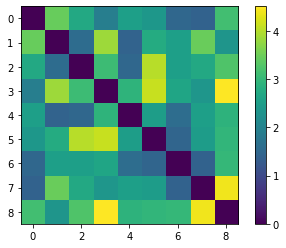

In [868]:
plt.imshow(np.array(squareform(distances)))
plt.colorbar()

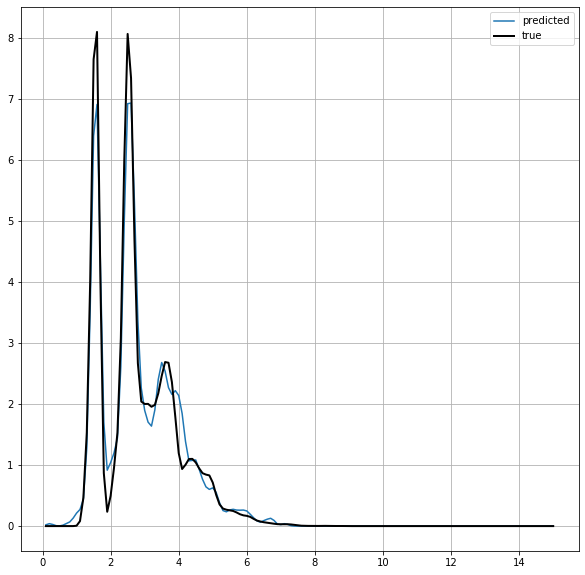

In [869]:
#plt.plot(np.linspace(0.1, 10, 200), calcRDF(np.array(all_distances).flatten()), label='predicted')

plt.figure(figsize=(10,10))
plt.plot(np.linspace(0.1, 15, 150), calcRDF2(np.array(all_distances).flatten()), label='predicted')
#for d in all_distances:
#    plt.plot(np.linspace(0.1, 10, 200), calcRDF(np.array(d).flatten()), linewidth=0.25)
plt.plot(np.linspace(0.1, 15, 150), calcRDF2(edms_flat), label='true', c='k', linewidth=2)
plt.grid()
plt.legend()

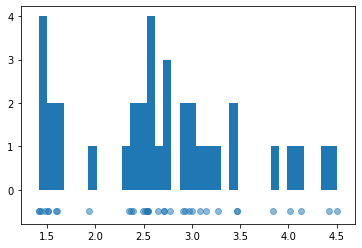

In [870]:
plt.hist(distances, bins=36)
plt.scatter(distances, np.zeros(len(distances))-0.5, alpha=0.5)
#plt.xlim(0,10)

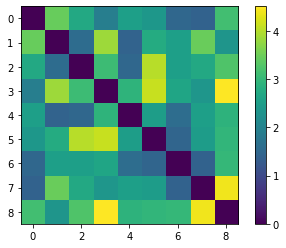

In [871]:
edm= squareform(distances)
plt.imshow(squareform(distances))
plt.colorbar()

In [872]:
#Neater:
#https://github.com/google/jax/issues/1397
    
#edm = squareform(all_distances[1])
edm = squareform(distances)    

def to_M_matrix(D):
    D1j = np.tile(D[0, :], len(D)).reshape(D.shape)
    Di1 = D1j.T
    return .5 * (-D + D1j + Di1)

def setPositions(mol_in, coords):
    conformer = mol_in.GetConformer(0)
    for i in range(mol_in.GetNumAtoms()):
        x,y,z = coords[i]
        conformer.SetAtomPosition(i,Point3D(x,y,z))
    return mol_in

D = edm**2
M = to_M_matrix(D)
S, U = np.linalg.eigh(M)

coord = np.matmul(U, np.diag(np.sqrt(np.abs(S))))
X = coord[:, -3:]


In [873]:
def get_proto_mol(atomicNumList):
    mol = Chem.MolFromSmarts("[#"+str(atomicNumList[0])+"]")
    rwMol = Chem.RWMol(mol)
    for i in range(1,len(atomicNumList)):
        a = Chem.Atom(atomicNumList[i])
        rwMol.AddAtom(a)

    mol = rwMol.GetMol()

    return mol


def xyz2AC(atomicNumList,xyz):
    import numpy as np
    mol = get_proto_mol(atomicNumList)

    conf = Chem.Conformer(mol.GetNumAtoms())
    for i in range(mol.GetNumAtoms()):
        conf.SetAtomPosition(i,(float(xyz[i][0]),float(xyz[i][1]),float(xyz[i][2])))
    mol.AddConformer(conf)

    dMat = Chem.Get3DDistanceMatrix(mol)
    pt = Chem.GetPeriodicTable()

    num_atoms = len(atomicNumList)
    AC = np.zeros((num_atoms,num_atoms)).astype(int)

    for i in range(num_atoms):
        a_i = mol.GetAtomWithIdx(i)
        Rcov_i = pt.GetRcovalent(a_i.GetAtomicNum())*1.2
        for j in range(i+1,num_atoms):
            a_j = mol.GetAtomWithIdx(j)
            Rcov_j = pt.GetRcovalent(a_j.GetAtomicNum())*1.2
            if dMat[i,j] <= Rcov_i + Rcov_j:
                AC[i,j] = 1
                AC[j,i] = 1

    return AC,mol


--------------
_Remember_ - you can use either the EDM-coords or the real coordinates to generate a molecule



Somehow these are different. They should be the same!!

In [898]:
atomicNumList = [6]*9

#coords = decode(p, noise,rng=key).reshape(numsamples,-1)[2].reshape(9,3)

#use either 'X' or 'coords'
#am, mol =xyz2AC(atomicNumList,coords[0].reshape(9,3))
am, mol =xyz2AC(atomicNumList,many_distances[8])

In [899]:



mol = get_proto_mol(atomicNumList)
eMol = Chem.EditableMol(mol)

bonds = np.triu(am)
for j, k in zip(onp.where(bonds)[0], onp.where(bonds)[1]):
    print(j,k)
    try:
        eMol.AddBond(int(j),int(k))
    except:
        None

0 7
2 4
6 7
6 8
7 8


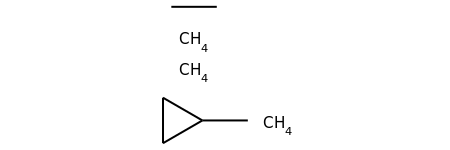

In [900]:
mol = eMol.GetMol()

Chem.rdmolfiles.MolToPDBFile(mol, 'tempmol.pdb', flavor=0)
mol

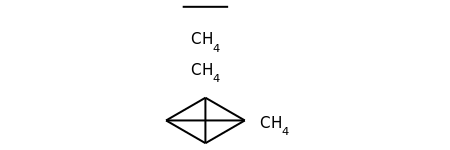

In [825]:
mol.Compute2DCoords()
mol